In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random

from gpdm import GPDM
from dataset_utils.mocap_labels import WALK_TRIALS, RUN_TRIALS
import dataset_utils.select_joints as select_joints

In [44]:
print(f"Number of walk trials: {len(WALK_TRIALS)}")
print(f"Number of run trials: {len(RUN_TRIALS)}")

Number of walk trials: 31
Number of run trials: 27


In [45]:
reduced_columns = WALK_TRIALS[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [46]:
walk_dfs = [trial.as_dataframe() for trial in WALK_TRIALS]
run_dfs = [trial.as_dataframe() for trial in RUN_TRIALS]

walk_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::10, :] for df in walk_dfs]
run_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::10, :] for df in run_dfs]

In [47]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [48]:
walk_gpdm = GPDM(
        D=DOFs,
        d=d,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [49]:
# sample 5 random walk sequences for training

walk_arrs_train = random.sample(walk_arrs, 5)

for walk_arr in walk_arrs_train:
    walk_gpdm.add_data(walk_arr)

print('Num. of sequences = '+str(walk_gpdm.num_sequences)+' [Data points = '+str(np.concatenate(walk_gpdm.observations_list, 0).shape[0])+']')


Num. of sequences = 5 [Data points = 158]



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 2.1378e+06
Update time: 0.03247952461242676

GPDM Opt. EPOCH: 10
Running loss: 8.0195e+05
Update time: 0.43607211112976074

GPDM Opt. EPOCH: 20
Running loss: 3.6994e+05
Update time: 0.21200919151306152

GPDM Opt. EPOCH: 30
Running loss: 1.9798e+05
Update time: 0.1514439582824707

GPDM Opt. EPOCH: 40
Running loss: 1.0399e+05
Update time: 0.15158295631408691

GPDM Opt. EPOCH: 50
Running loss: 5.6969e+04
Update time: 0.16045117378234863

GPDM Opt. EPOCH: 60
Running loss: 3.1336e+04
Update time: 0.2071363925933838

GPDM Opt. EPOCH: 70
Running loss: 2.0940e+04
Update time: 0.14281821250915527

GPDM Opt. EPOCH: 80
Running loss: 1.7264e+04
Update time: 0.1333458423614502

GPDM Opt. EPOCH: 90
Running loss: 1.5510e+04
Update time: 0.13529586791992188

GPDM Opt. EPOCH: 100
Running loss: 1.4207e+04
Update time: 0.13135623931884766

GPDM Opt. EPOCH: 110
Running loss: 1.3123e+04
Update time: 0.14994192123413086

GPDM Opt. EPOCH: 120
R

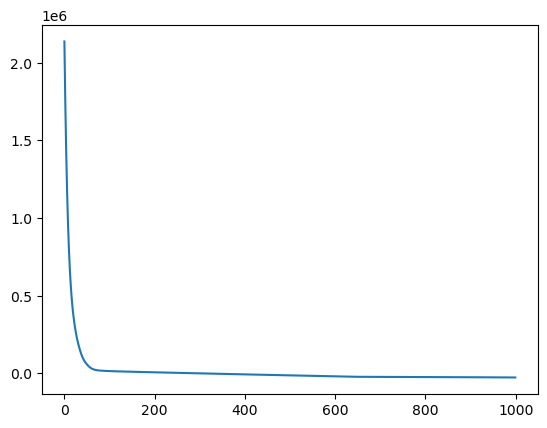

In [50]:
walk_gpdm.init_X()  
losses = walk_gpdm.train_adam(num_opt_steps=1000, num_print_steps=10, lr=0.05)

walk_gpdm.save('walk_gpdm_config.pth', 'walk_gpdm_state.pth')  

plt.plot(losses)

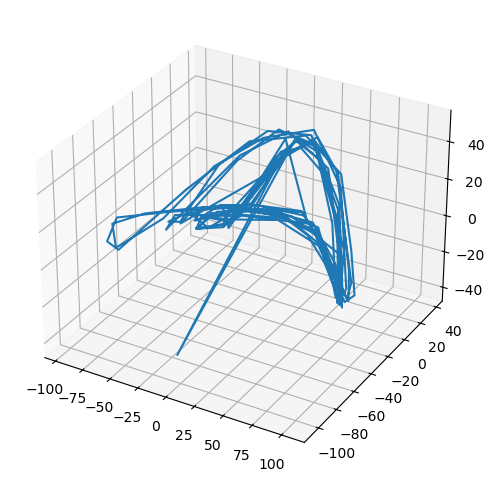

In [51]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X = walk_gpdm.X.detach().numpy()
ax.plot(X[:, 0], X[:, 1], X[:, 2])